In [34]:
import pandas as pd
import seaborn as sns
import numpy as np

#### Import all sheets and examine the data

In [21]:
df1 = pd.read_excel('./gorilla_test_data.xlsx', sheet_name=0)
df2 = pd.read_excel('./gorilla_test_data.xlsx', sheet_name=1)
df3 = pd.read_excel('./gorilla_test_data.xlsx', sheet_name=2)

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   meter_id   4 non-null      int64 
 1   aq_kwh     4 non-null      int64 
 2   exit_zone  4 non-null      object
dtypes: int64(2), object(1)
memory usage: 224.0+ bytes


In [5]:
df1

,meter_id,aq_kwh,exit_zone
0,14676236,28978,EA1
1,34509937,78324,SO1
2,50264822,265667,NT1
3,88357331,484399,SE2


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3412 entries, 0 to 3411
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   meter_id  3412 non-null   int64         
 1   date      3412 non-null   datetime64[ns]
 2   kwh       3412 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 80.1 KB


In [7]:
df2

,meter_id,date,kwh
0,14676236,2020-06-01,22.070768
1,14676236,2020-06-02,19.170720
2,14676236,2020-06-03,23.555111
3,14676236,2020-06-04,18.220712
4,14676236,2020-06-05,14.196134
...,...,...,...
3407,88357331,2022-09-27,441.014725
3408,88357331,2022-09-28,441.512055
3409,88357331,2022-09-29,437.240657
3410,88357331,2022-09-30,517.608354


#### Checking for gaps in the consumption dates

In [8]:
# check date index extremes
df2[['date']].describe(datetime_is_numeric=True).T[['min', 'max']]

,min,max
date,2020-06-01,2022-10-01


In [9]:
# # checking for missing values in the date index
assert len(pd.date_range(start = '2020-06-01', end = '2022-10-01' )) == len(set(pd.to_datetime(df2['date']).values))


In [10]:
# # checking for missing values in the date index
assert len(set(np.asarray(pd.date_range(start = '2020-06-01', end = '2022-10-01' ))).difference(pd.to_datetime(df2['date']).values)) == 0


#### Join meter AQ data with daily consumption

In [11]:
consumption_info = df2.join(df1.set_index('meter_id'), how='left', sort=False, on='meter_id')

In [12]:
# check the merge was correct and no observations were lost
assert len(consumption_info)== len(df2)

In [13]:
# for future joins
consumption_info['date'] = consumption_info['date'].dt.to_period('D')

In [22]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1140 non-null   datetime64[ns]
 1   exit_zone       1140 non-null   object        
 2   aq_min_kwh      1140 non-null   int64         
 3   aq_max_kwh      760 non-null    float64       
 4   rate_p_per_kwh  1140 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 44.7+ KB


In [23]:
df3

,date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh
0,2020-04-01,EA1,0,73200.0,0.2652
1,2020-04-01,EA1,73200,732000.0,0.1980
2,2020-04-01,EA1,732000,NaN,0.2875
3,2020-04-01,EA2,0,73200.0,0.2970
4,2020-04-01,EA2,73200,732000.0,0.1524
...,...,...,...,...,...
1135,2024-10-01,WM2,73200,732000.0,0.4537
1136,2024-10-01,WM2,732000,NaN,0.7534
1137,2024-10-01,WM3,0,73200.0,0.7263
1138,2024-10-01,WM3,73200,732000.0,0.6109


#### fill missing values in the upper bracket
#### for lack of domain knowledge, similar to the middle bracket the upper bracket will be aq_min * 10


In [24]:
df3['aq_max_kwh'].fillna(7320000, inplace=True)

In [25]:
# check the nulls are gone
assert df3.isnull().sum().std() ==0

In [26]:
# change datetimeindex to period index for joins
df3['date'] = df3['date'].dt.to_period('D')

In [27]:
# adding a categorical variable to describe the rates bracket for plotting or filtering
df3['rate_type'] = df3['aq_min_kwh'].map({0 : 'bracket 1', 73200 : 'bracket 2', 732000 : 'bracket 3'})

#### Noting only 10 unique dates vs 853 in the consumption dataset

In [28]:
df3[['date']].describe().T

,count,unique,top,freq
date,1140,10,2020-10-01,114


#### checking each exit zone has the same number of observations for each of the periods

In [29]:
df3.groupby('date').count().std() 

exit_zone         0.0
aq_min_kwh        0.0
aq_max_kwh        0.0
rate_p_per_kwh    0.0
rate_type         0.0
dtype: float64

#### Observe: the rates increase every period, but we only have 10 observations, so need to interpolate to fill missing data for remaining 843 periods

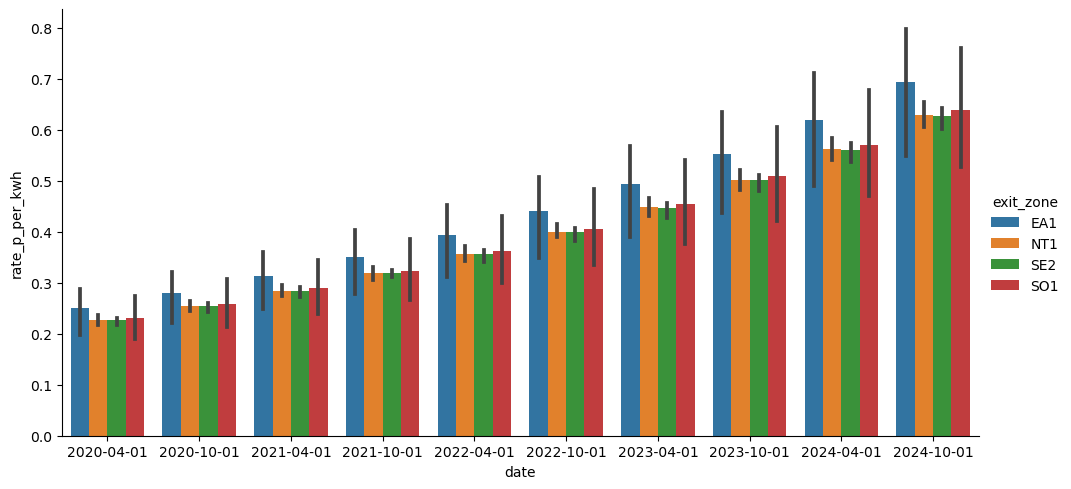

In [43]:
# filter dataset to known exit_zone codes
d = df3[df3['exit_zone'].isin(df1['exit_zone'].unique())]

g = sns.catplot(data=d,
                x='date', y = 'rate_p_per_kwh',
                hue='exit_zone', aspect=2, kind='bar')
# g.set_xticklabels(rotation=60)

In [44]:
from itertools import product, combinations

# complete missing date information for interpolation for each of the exit_zones

start = '2020-04-01'
end = '2022-10-01'

dates_range = pd.period_range(start=start, end=end, freq='D')
dates_range

complete_period = pd.DataFrame(product(consumption_info['exit_zone'].unique(),
                                        dates_range), columns=['exit_zone', 'date'],

                              )

In [45]:
complete_period.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype    
---  ------     --------------  -----    
 0   exit_zone  3656 non-null   object   
 1   date       3656 non-null   period[D]
dtypes: object(1), period[D](1)
memory usage: 57.2+ KB


#### augment rates dataset with daily observations

In [49]:
daily_rates = complete_period.merge(df3, on =['exit_zone', 'date'], how='left')
daily_rates.isnull().sum()

exit_zone            0
date                 0
aq_min_kwh        3632
aq_max_kwh        3632
rate_p_per_kwh    3632
rate_type         3632
dtype: int64

#### assuming the rates hold until the following period, forward fill is used to populate missing values

In [50]:
daily_rates_complete = pd.concat([df3[(df3['rate_type']==bracket) & 
     df3['exit_zone'].isin(consumption_info['exit_zone'].unique())
   ].merge(complete_period,on=['exit_zone', 'date'],how='right').fillna(method='ffill')
 for bracket in ['bracket 1', 'bracket 2', 'bracket 3']], axis=0)

# check rates distribution resembles the original
daily_rates_complete.describe()

,aq_min_kwh,aq_max_kwh,rate_p_per_kwh
count,10968.000000,1.096800e+04,10968.000000
mean,268400.000000,2.708400e+06,0.296818
std,329189.003678,3.272115e+06,0.059597
min,0.000000,7.320000e+04,0.190200
25%,0.000000,7.320000e+04,0.253700
50%,73200.000000,7.320000e+05,0.290800
75%,732000.000000,7.320000e+06,0.341300
max,732000.000000,7.320000e+06,0.506700


In [52]:
daily_consumption = consumption_info.merge(
    daily_rates_complete, on=list(set(consumption_info.columns).intersection(daily_rates.columns)),
    how='left')

In [54]:
# check no null values appeared after join
assert daily_consumption.isnull().sum().std()==0

In [58]:
# filter out irrelevant rates 
df4 = daily_consumption[(daily_consumption['aq_kwh']>= daily_consumption['aq_min_kwh']) & 
                  (daily_consumption['aq_kwh'] < daily_consumption['aq_max_kwh'])]


In [61]:
# check the daily rates post joins have the same number of observations as the daily consumptino forecast table
assert len(df4) == len(df2)

# Q1: Calculate the total cost per meter by summing its daily charges for the full forecast period and converting to Pounds (1p = 0.01£).

In [63]:
df4['TC_GBP'] = ((df4['kwh']*df4['rate_p_per_kwh'])*0.01)

/home/nlawranc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
summary = df4.groupby('meter_id', as_index=True).sum()[['kwh', 'TC_GBP']].round(2).rename({'kwh' : 'TotalEstimatedConsumption (kwh)',
                                                          'TC_GBP' : 'TotalCost (GBP)'}, axis=1).reset_index()
summary

,meter_id,TotalEstimatedConsumption (kwh),TotalCost (GBP)
0,14676236,28978.0,100.15
1,34509937,78324.0,275.49
2,50264822,265667.0,731.24
3,88357331,484399.0,1433.16


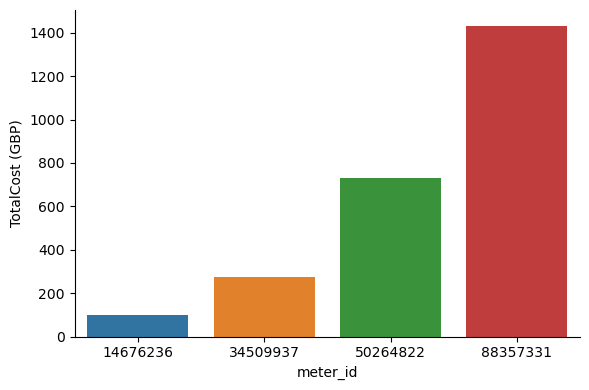

In [68]:
sns.catplot(data = summary, x='meter_id', y='TotalCost (GBP)', kind='bar', height=4, aspect = 1.5
            )

# Q2. Write a function that generates a list of random meters of any size. Examples of valid exit zones can be found in the rate table. You may randomly generate the annual quantity.

In [69]:
from random import uniform, randint, randrange

In [110]:
def gen_aq(rates_bracket):
    
    """ Function that samples AQ from the uniform distribution according to the rates bracket.
    
    Parameters
    ----------
    rates_bracket : str
        Possible options are: ['braket 1', 'bracket 2', 'bracket 3']

    Returns
    -------
    float
        A random number from a specified range
    """
    
    if rates_bracket == 'bracket 1':
        return uniform(0,73200)
    elif rates_bracket == 'bracket 2':
        return uniform(73200,732000)
    elif rates_bracket == 'bracket 3':
        return uniform(732000,7320000)
    else:
        return print('Unknown bracket type')

def sample_meters(input_df, seed):
    """Function that picks a random sample from the available exit zone and rates table 
    and generates an appropriate AQ according to the sampled bracket and a random meter_id.

    Parameters
    ----------
    input_df : pandas dataframe
        a dataframe to sample from
    seed : int 
        a positive integer to set the random_state 

    Returns
    -------
    pandas df
        A dataframe

    """
    
    
    #sample one row with replacement
    sample = input_df.sample(n=1,
                             replace=True,
                             random_state=seed,
                             axis=0)

    # generate random number within rates boundaries
    sample['aq_kwh'] = sample['rate_type'].apply(gen_aq)

    # generate a random 8-digit meter_id
    sample['meter_id'] = np.random.randint(10000000,99999999, size=1)
    
    return sample[['meter_id','aq_kwh', 'exit_zone']]

def gen_a_list_of_meters(input_df, list_size):
    """ A function to generate a list of random meters.
    
    
    Parameters:
    
    input_df: pandas dataframe
        a dataframe containing rates for various exit zones
    list_size : int
        an integer indicating the size of the desired list of random meters
    
    Returns:
    
    list: a list of pandas dataframes (dim 1x3) of specified in parameters list_size
        
    """
    
    return [sample_meters(input_df,seed=i) for i in np.random.randint(0,100,size=list_size)]

In [111]:
list_of_3 = gen_a_list_of_meters(df3, list_size=10)
list_of_3

[     meter_id        aq_kwh exit_zone
 174  52398355  50025.907471       NT3,
      meter_id        aq_kwh exit_zone
 681  15595161  65191.929552       WM3,
       meter_id        aq_kwh exit_zone
 1013  25967463  4.012077e+06       WA1,
      meter_id        aq_kwh exit_zone
 969  90172172  22623.251723       NT2,
       meter_id        aq_kwh exit_zone
 1044  80093480  48911.604719       EM3,
      meter_id        aq_kwh exit_zone
 426  46269762  52581.292256       SO1,
      meter_id        aq_kwh exit_zone
 971  54733824  3.578140e+06       NT2,
       meter_id        aq_kwh exit_zone
 1022  47124836  4.168995e+06       WM2,
     meter_id        aq_kwh exit_zone
 90  13381443  18049.538305       SW1,
      meter_id        aq_kwh exit_zone
 248  36170328  5.205611e+06       EM3]

In [112]:
cp = cProfile.run("gen_a_list_of_meters(df3, list_size=1000)")

         4760015 function calls (4703015 primitive calls) in 4.133 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    0.001    0.000    0.004    0.000 48974904.py:1(gen_aq)
     1000    0.015    0.000    4.123    0.004 48974904.py:25(sample_meters)
        1    0.000    0.000    4.131    4.131 48974904.py:58(gen_a_list_of_meters)
        1    0.007    0.007    4.131    4.131 48974904.py:75(<listcomp>)
     4000    0.004    0.000    0.051    0.000 <__array_function__ internals>:2(append)
     2000    0.002    0.000    0.015    0.000 <__array_function__ internals>:2(argsort)
     4000    0.004    0.000    0.023    0.000 <__array_function__ internals>:2(atleast_2d)
     2000    0.002    0.000    0.007    0.000 <__array_function__ internals>:2(bincount)
     3000    0.004    0.000    0.013    0.000 <__array_function__ internals>:2(can_cast)
    13000    0.015    0.000    0.066    0.000 <__array_function__ internals>:2

# 3. Write a function that generates mock consumption data given a list of meters and a start date and duration (number of days in the forecast). The data may be completely random and it doesn't have to match with the meters' annual quantities either.

In [113]:

def gen_mock_consumption(meters_list, start_date, n_periods):
    """ A function to generate random meter consumption data.
    
    Parameters
    ----------
    
    meters_list (list): a list of dataframes containing rates for various exit zones
    

    start_date : str
        a string of the format 'YYYY-MM-DD' 
    n_periods : int 
        a positive integer specifying a number of daily observations required to be generated

    Returns
    -------
    pandas df
        A dataframe of the shape (meters_list*n_periods)x3
        
    """
    
    
    dfs_list = []
    for meter in meters_list:
        
        dti =  pd.date_range(start = start_date, periods=n_periods, freq = 'D')
        kwh = np.random.uniform(df2['kwh'].min(), df2['kwh'].max(), size=n_periods)
        
        dfs_list.append(pd.DataFrame({'meter_id' : list(meter['meter_id'].values)*n_periods,
                                      'date' : dti,
                                      'kwh' : kwh
                                      }
                                    )
                        )
    return pd.concat(dfs_list, axis=0)

In [114]:
gen_mock_consumption(list_of_3, start_date='2010-01-01', n_periods=3)

,meter_id,date,kwh
0,52398355,2010-01-01,19.360450
1,52398355,2010-01-02,608.590144
2,52398355,2010-01-03,708.879296
0,15595161,2010-01-01,894.975659
1,15595161,2010-01-02,628.580511
2,15595161,2010-01-03,1153.136259
0,25967463,2010-01-01,53.728183
1,25967463,2010-01-02,473.873767
2,25967463,2010-01-03,319.149085
0,90172172,2010-01-01,355.616200


In [101]:
timing = {}
for p in [10,50,100,1000,10000,10000]:
    t = %timeit -n5 -r100 -o gen_mock_consumption(list_of_3, start_date='2020-01-01', n_periods=p)
    timing[p] = t
        
pd.DataFrame({'n_runs' : [100]*len(timing.keys()),
              'n_loops' : [5]*len(timing.keys()),
    'n_periods' : [k for k in timing.keys()],
 'average time in s' : [v.average for v in timing.values()],
 'stdev time in s' : [v.stdev for v in timing.values()]})

8.93 ms ± 1.53 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
9.52 ms ± 2.45 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
9.57 ms ± 1.64 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
10.1 ms ± 1.5 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
35.1 ms ± 7.58 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
46.9 ms ± 14.6 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)


,n_runs,n_loops,n_periods,average time in s,stdev time in s
0,100,5,10,0.008933,0.001526
1,100,5,50,0.009516,0.002448
2,100,5,100,0.009571,0.001637
3,100,5,1000,0.010059,0.001496
4,100,5,10000,0.046945,0.014567


# Q4.Write a function that takes as an input a meter list and a consumption forecast table and that calculates the transportation cost table (i.e., best take your logic from task 1 and wrap it in a functin). 


In [115]:

def calculate_transportation_costs(meter_list, consumption_forecast, rates_df):
    """ A function to calculate total transportation costs from randomly generated consumption data.
    
    
    Parameters
    ----------
    
    meters_list: list
        a list of dataframes containing rates for various exit zones
    
    consumption_forecast: pandas df
        a dataframe of shape n x 3 containing information in daily consumption volumes in kwh per meter_id
    rates_df : pandas df
        a pandas dataframe containing information on transportation costs per exit_zone 

    Returns
    -------
    pandas df
        A dataframe of the shape (meters_list)x2 with infromation on total consumption per meter in kwh \n
        and total cost in GBP
        
    """
    
    df1 = pd.concat(meter_list, axis=0)
    df2 = consumption_forecast
    df3 = rates_df

    # Join meter AQ data with daily consumption
    consumption_info = df2.merge(df1, on='meter_id', how='left')  
    # change datetimeindex to period index for merge
    consumption_info['date'] = consumption_info['date'].dt.to_period('D')
    # change datetimeindex to period index for merge
    #     df3['date'] = df3['date'].dt.to_period('D')
    # assuming the missing values have already been filled in
    df3['aq_max_kwh'].fillna(7320000, inplace=True)
    #
    dates_range = pd.period_range(start=df3['date'].min(), end=df3['date'].max(), freq='D')
    dates_range

    # complete missing date information for interpolation for each of the exit_zones

    complete_period = pd.DataFrame(product(consumption_info['exit_zone'].unique(),
                                        dates_range), columns=['exit_zone', 'date'],

                              )
    # augment rates dataset with daily observations
    daily_rates = complete_period.merge(df3, on =['exit_zone', 'date'], how='left')



    daily_rates_complete = pd.concat([df3[(df3['rate_type']==bracket) & 
                                           df3['exit_zone'].isin(consumption_info['exit_zone'].unique())

                                         ].merge(complete_period,on=['exit_zone', 'date'],how='right'
                                                ).fillna(method='ffill')
                                      for bracket in ['bracket 1', 'bracket 2', 'bracket 3']], axis=0)

    daily_consumption = consumption_info.merge(daily_rates_complete, on=['date', 'exit_zone'],how='left')

    daily_consumption['TC_GBP'] = (daily_consumption['kwh']*daily_consumption['rate_p_per_kwh'])*0.01
    # filter on relevant AQ only and summarise
    df4 = daily_consumption[(daily_consumption['aq_kwh']>= daily_consumption['aq_min_kwh']) & 
                      (daily_consumption['aq_kwh'] < daily_consumption['aq_max_kwh'])]

    return df4.groupby('meter_id', as_index=True).sum()[['kwh', 'TC_GBP']].round(2).rename({'kwh' : 'TotalEstimatedConsumption (kwh)',
                                                          'TC_GBP' : 'TotalCost (GBP)'}, axis=1).reset_index()

In [120]:
list_of_3 = gen_a_list_of_meters(df3, list_size=3)
mock_consumption_data = gen_mock_consumption(meters_list=list_of_3, start_date='2020-01-01', n_periods=100)

cp = cProfile.run('calculate_transportation_costs(list_of_3, mock_consumption_data, df3)')

         80214 function calls (79588 primitive calls) in 0.083 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.083    0.083 593295818.py:1(calculate_transportation_costs)
        1    0.000    0.000    0.034    0.034 593295818.py:51(<listcomp>)
       10    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(all)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(append)
       12    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argsort)
        4    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(array_equal)
       17    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(bincount)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(broadcast_to)
       29    0.000    0.000    0.00

# Benchmark this function using meter lists of different sizes and consumption forecasts for periods of different lengths. 
# How does the function scale for larger sets of data?

In [125]:
n_meters = [3,10,100,1000,10000]
n_periods = [5,10,30,100,200,500,1000]

timeit_list=[]
for m,p in product(n_meters,n_periods):
    
    meters = gen_a_list_of_meters(df3, list_size=m)
    consumption = gen_mock_consumption(meters, start_date='2020-04-01', n_periods=p)
    t = %timeit -n5 -r5 -o calculate_transportation_costs(meters, consumption, df3)
    timeit_list.append(t)

39.1 ms ± 3.53 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
54 ms ± 6.55 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
56.8 ms ± 6.88 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
50.8 ms ± 5.05 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
50.3 ms ± 5.12 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
49.5 ms ± 5.17 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
58.7 ms ± 8.96 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
85.4 ms ± 17.8 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
76.4 ms ± 8.1 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
81.7 ms ± 6.06 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
78.8 ms ± 19.1 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
82.6 ms ± 11.4 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
113 ms ± 23.3 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
108 ms ± 13.6 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
193 ms ± 31.7 ms per loop

In [134]:

tdf = pd.concat([pd.DataFrame({'n_meters' : params[0],
                  'n_periods' : params[1],
                  'timeit_avg' : [data.average],
                 'timeit_stdev' : [data.stdev],
                 }) for params, data in zip([i for i in product(n_meters,n_periods)], timeit_list)]).reset_index(drop=True)

tdf.to_csv('benchmarking_data.csv', index=False, header=True)



,n_meters,n_periods,variable,value
0,3,5,timeit_avg,0.039071
1,3,10,timeit_avg,0.054028
2,3,30,timeit_avg,0.056847
3,3,100,timeit_avg,0.050760
4,3,200,timeit_avg,0.050269
...,...,...,...,...
100,10000,30,minus_std,1.619895
101,10000,100,minus_std,2.404190
102,10000,200,minus_std,3.490527
103,10000,500,minus_std,6.502522


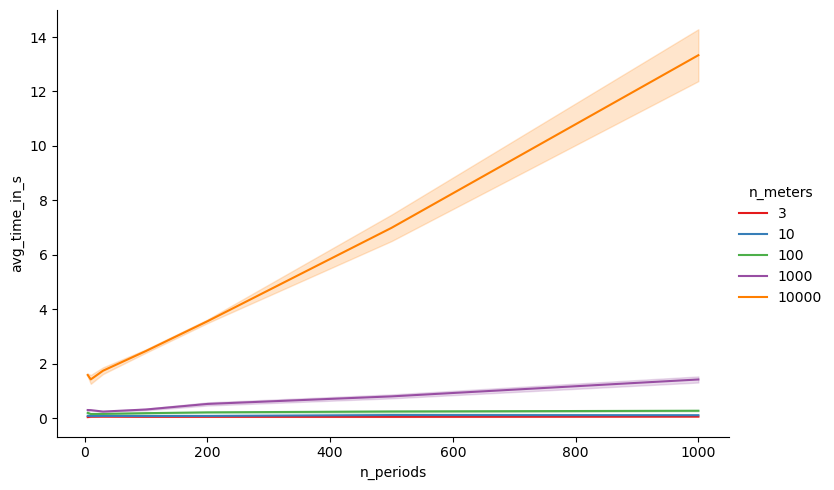

In [146]:
# calculate values with stdev and reshape table to show the variance
tdf['plus_std'] = tdf['timeit_avg']+tdf['timeit_stdev']
tdf['minus_std'] = tdf['timeit_avg'] - tdf['timeit_stdev']
d = tdf.melt(id_vars=['n_meters', 'n_periods'],
          value_vars = ['timeit_avg', 'plus_std', 'minus_std'], value_name='avg_time_in_s')
sns.relplot(data=d,y='avg_time_in_s', palette='Set1',
            x='n_periods', hue='n_meters',aspect=1.5,  height=5, kind='line'
           )

# Q 5. What are your observations after benchmarking? Are there any steps in the cost calculation that can be improved? 
# How would you go about improving the performance of this calculation?

Since the function involves several joins, filling missing values and lists of dataframes so it's not surprising it doesn't scale well to very large datasets.
Data joins can possibly be improved with explicit indexing. Instead of a list of meters a table/array of meters can be used as an input.